# COMM2550 Spring 2023 
# **Does Light Affect Crime?**

## By: Annabel Sumardi and Michael Li 
---
## Asking questions on the presence of street lights and crime in the Philadelphia datasets 
- Looking into whether light affects amount of crime

### The dataset 
- Data is available on opendataphilly.org
    - *Street Light data*: https://opendataphilly.org/datasets/street-poles/ 
    - *Crime data*: https://opendataphilly.org/datasets/crime-incidents/
    - *Philly Police District data*: https://opendataphilly.org/datasets/police-districts/

---

- [Police District Metadata](https://metadata.phila.gov/#home/datasetdetails/5543866f20583086178c4f24/representationdetails/55438ab79b989a05172d0d5b/)
- [Crime Metadata](https://metadata.phila.gov/#home/datasetdetails/5543868920583086178c4f8e/representationdetails/570e7621c03327dc14f4b68d/)
- [Street Pole Metadata](https://metadata.phila.gov/#home/datasetdetails/555f8135f15fcb6c6ed4413a/representationdetails/5571b1c4e4fb1d91393c2183/)

---

- CSV Version: 
    - `../data/philly.csv`
    - `../data/philly.geojson`
    - `../data/Street_Poles.csv`
    - `../data/Street_Poles.geojson`
    - `../data/crime.csv`
    - `../data/philadelphia_sunset_2022.tsv`
    
---

* Related articles
    * https://urbanlabs.uchicago.edu/projects/crime-lights-study
    * https://popcenter.asu.edu/content/improving-street-lighting-reduce-crime-residential-areas-page-2 


## <font color="blue"> Setup </font> 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import wkt

import contextily as cx

import warnings
warnings.filterwarnings('ignore')

## <font color="blue"> Import Philly District Data </font> 

- Importing **Philly Police District** boundaries, including a function which will allow the district numbers to be illustrated graphically
- This data will be used to plot our street pole and crime data on a PPD district map visualization.
- We will use a GeoPandas `GeoDataFrame` in order to do geospatial analysis with the `geometry` column


In [3]:
# imported from 3_opendataphilly_shooting, from Prof. O'Donnell
def show_district_nums(r, fcol='black'):
    plt.text(r['centX'], 
           r['centY'], 
           r['DIST_NUM'], 
           horizontalalignment='center',
           verticalalignment='center', fontsize=8, color=fcol)

In [4]:
districts_gdf = gpd.read_file('../data/philly.geojson')

## <font color="blue"> Inspect the District Data </font> 

- Regard the following variables in the district data: `District Number`, `Location`, and `Geometry`
    - We will use these variables to help sort our data by location.

In [5]:
# update 4/22, changing district column for simpler use later on (data cleaning/bigfixing)
districts_gdf.rename(columns={'DISTRICT_': 'district'}, inplace=True)
districts_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry
0,343,None,69282.588463,16,None,16,None,16,39th St. & Lancaster Ave.,686-3160,SWPD,1.216700e+08,1.927226e+07,27575.079183,"POLYGON ((-75.19957 40.00912, -75.19799 40.008..."
1,344,None,33150.154961,17,None,17,None,17,20th St. & Federal St.,686-3170,SPD,5.786368e+07,9.154950e+06,13179.953350,"POLYGON ((-75.16599 39.94184, -75.16621 39.940..."
2,345,None,54403.930038,18,None,18,None,18,55th St. & Pine St.,686-3180,SWPD,9.881929e+07,1.564117e+07,21629.610687,"POLYGON ((-75.18466 39.94851, -75.18633 39.947..."


## <font color="blue"> Plot the District Data </font> 

- This graph will be the base for our following graphs, where we can split data by district number to look into certain districts if there are any interesting cases or regions.
- We are adding the district numbers in the center of each shape here. 

### <font color="blue"> Steps </font>
1. Join district data
2. Plot districts on the map of Philly
3. Use this graph as the base for our upcoming heatmaps, hexbins, etc. 

In [6]:
# Check the CRS (coordinate reference system) for data
# important to make sure all geo sources in the same CRS
# when you do joins 
districts_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

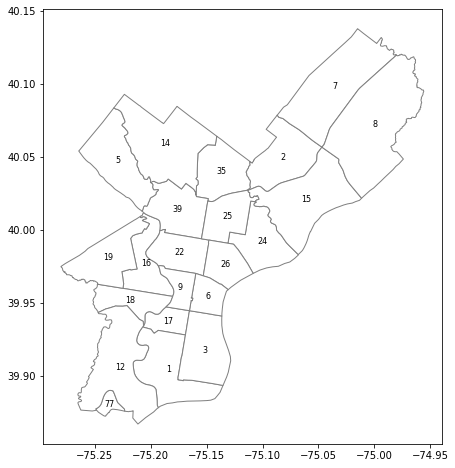

In [7]:
districts_gdf['centX']=districts_gdf['geometry'].centroid.x
districts_gdf['centY']=districts_gdf['geometry'].centroid.y
districts_gdf.plot(color='white', edgecolor='gray', figsize=(8,8))
districts_gdf.apply(show_district_nums, axis=1)
plt.show()

## <font color="green"> Import the Street Light Data </font> 

*Note the .. is to allow the data to read from the data folder, since it is stuck in the data_analysis folder without the extra piece of syntax

* **NOTE** - try and set data projects up so all file paths and references are **RELATIVE** so if it goes up to github or is distributed in someway there is nothing hard coded, e.g. NOT `/users/username/files/projects` or `C:\My Documents\Projects\`. It is amazing how often you see this on publicly distributed projects!
* Now, let's load the Street Poles data using `pandas` and `geopandas` 

In [8]:
street_poles_df = pd.read_csv('../data/Street_Poles.csv')
street_poles_gdf = gpd.read_file('../data/Street_Poles.geojson')

## <font color="green"> Inspect the Street Light Data </font> 

- Note the variables `x` and `y`, which will have to be converted to find which districts they lie in since that is not automatically provided

In [9]:
# fidget around with this more to figure out more nuances to street pole data (i.e. if illumination matters)
street_poles_df.head(3)

,X,Y,OBJECTID,OID,POLE_NUM,TYPE,NLUMIN,LUM_SIZE,HEIGHT,POLE_DATE,UP_DATE,OWNER,TAP_ID,BLOCK,PLATE
0,-75.066411,40.044774,1,0,1,WP,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN
1,-75.061178,40.041861,2,0,3,TCB,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN
2,-75.144451,40.008283,3,0,4,WP,NaN,NaN,NaN,NaN,NaN,Streets,NaN,NaN,NaN


### <font color="green"> What does our data inspection show us? </font>
    
* We can see the street pole data is separated into multiple columns, most importantly `geometry`, which we can use to graph where the light poles are in Philly
* The `.describe()` illustrates that the max pole ID is 195,680, meaning there is over 100K light poles in Philly. Because of the large amount, we will create a density plot to help illustrate where light poles are most present since just plotting points will cover most of the city without illustrating much nuance. 
    * Looking at the `count` value, the highest number of street poles is 195,680, so there's almost 200K street poles with inputted data in Philly.
* Another column of interest is the NLUMIN column, which displays the light lumin count. A higher lumin count correlates with a brighter light, so it would be good to note this when regarding how some street poles might be brighter than others. 
    - We look below to see how there are many different lumin counts, which means there is varying brightnesses of the poles. 
    - There appears to be mostly lumin counts of 1.0 or missing data, which hopefully implies general consistency so that if we do not account for the differences the data still comes to a similar conclusion.
* There also seems to be issues with the street pole date installation. The data is either missing or was not recorded in the first place. 

</div>

In [10]:
street_poles_gdf.head(3)

,OBJECTID,OID,POLE_NUM,TYPE,NLUMIN,LUM_SIZE,HEIGHT,POLE_DATE,UP_DATE,OWNER,TAP_ID,BLOCK,PLATE,geometry
0,1,0,1,WP,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.06641 40.04477)
1,2,0,3,TCB,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.06118 40.04186)
2,3,0,4,WP,NaN,NaN,NaN,None,None,Streets,NaN,None,None,POINT (-75.14445 40.00828)


In [11]:
street_poles_gdf.describe()

,OBJECTID,OID,POLE_NUM,NLUMIN,LUM_SIZE,HEIGHT,TAP_ID
count,195680.000000,195680.0,195680.000000,127250.000000,127250.000000,127250.000000,189306.000000
mean,97840.500000,0.0,413723.817943,1.139096,119.425713,23.201925,271003.571884
std,56488.094675,0.0,201181.932181,20.300365,62.158322,5.180471,253004.974118
min,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48920.750000,0.0,223944.750000,1.000000,100.000000,20.000000,0.000000
50%,97840.500000,0.0,415435.500000,1.000000,100.000000,25.000000,221839.000000
75%,146760.250000,0.0,600604.250000,1.000000,121.000000,25.000000,509248.750000
max,195680.000000,0.0,889111.000000,3614.000000,400.000000,45.000000,883426.000000


In [12]:
street_poles_gdf.dtypes

OBJECTID        int64
OID             int64
POLE_NUM        int64
TYPE           object
NLUMIN        float64
LUM_SIZE      float64
HEIGHT        float64
POLE_DATE      object
UP_DATE        object
OWNER          object
TAP_ID        float64
BLOCK          object
PLATE          object
geometry     geometry
dtype: object

In [13]:
street_poles_gdf['NLUMIN'].unique()
# varying brightness

array([      nan, 1.000e+00, 2.000e+00, 1.400e+01, 4.000e+00, 3.614e+03,
       3.200e+02, 1.380e+02, 0.000e+00])

In [14]:
# This can be treated as a categorical value
street_poles_gdf['NLUMIN'].value_counts(dropna=False)

1.0       124974
NaN        68430
2.0         2243
14.0          16
4.0            8
3614.0         4
320.0          2
0.0            2
138.0          1
Name: NLUMIN, dtype: int64

In [15]:
# Can look at it as proportions
street_poles_gdf['NLUMIN'].value_counts(dropna=False, normalize=True)*100


1.0       63.866517
NaN       34.970360
2.0        1.146259
14.0       0.008177
4.0        0.004088
3614.0     0.002044
320.0      0.001022
0.0        0.001022
138.0      0.000511
Name: NLUMIN, dtype: float64

### <font color="green"> Further Lumin Observations? </font>

* Almost 2/3 of lamps are 1 lumin and 1/3 have no value recorded - so no real variation in strength of light to work with here

In [16]:
# clean street_poles_gdf, redudundant cell, didn't end up using the cleaned one lol
simple_sp_gdf = street_poles_gdf[['OBJECTID', 'geometry']]
simple_sp_gdf.head(3)

,OBJECTID,geometry
0,1,POINT (-75.06641 40.04477)
1,2,POINT (-75.06118 40.04186)
2,3,POINT (-75.14445 40.00828)


## <font color="green"> Plot the Street Light Data </font> 

*Note that the street light data is extremely dense due to the amount of street lights in Philly. Thus, there is evidence of a couple blackout zones, but otherwise, most of the Philly map appears to be covered in data. The way we will deal with this is by heat mapping the data and other methods of showing street light density per district. 

## <font color="green"> Question: Is the geographical distribution of street lights denser in certain districts? </font>

### <font color="green"> Key columns </font>

* The police district field will be used for grouping to observe trends


### <font color="green"> Steps </font>

* Use the geometry data in the street pole data to map where the lights are present. 
* Try hexbin plots to illustrate where the lights are most dense. 
* An ideal plot type would allows us to plot the data onto a 2d map displaying the areas where street lights are most present in Philadelphian police districts expressed through different shading. 

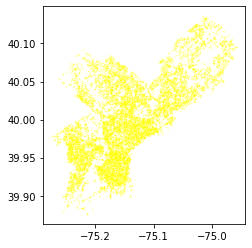

In [17]:
# too many points
# so don't try and plot all - instead take a sample
street_poles_gdf.sample(10_000).plot(markersize=1, alpha=0.2, color='yellow')
plt.show()


### <font color="green"> Some Hexbin Observations </font>
Below, the hexplot helps better illustrate density of the street lights in different regions. **Districts 6, 9, 17, 22, and 26** appear to have a dense amount of street lights compared to other areas in Philadelphia. 
- These areas correlate with where Center City is, covering down to Chinatown and up to Fishtown within its path. 
- This higher amount of street lights makes sense as these areas are downtown Philadelphia, where a dense amount of people either live there or visit there. Thus, safety would have to be a higher priority in these areas. 

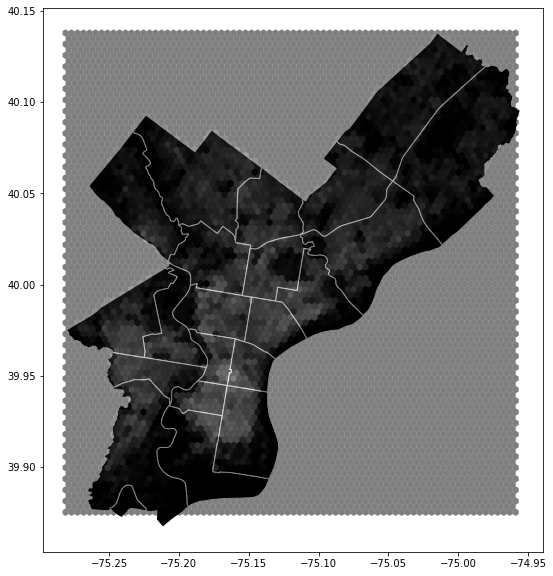

In [18]:
# trying to get a hexbin effect where low values are black (i.e. no/little light)
# and higher values go towards white overlay on basemap

fig,ax = plt.subplots(figsize=(10,10))
districts_gdf.plot(color='black', edgecolor='white', ax=ax)
ax.hexbin(x=street_poles_df['X'],
          y=street_poles_df['Y'],
          gridsize=75, edgecolor=None,
          alpha=0.5, cmap='binary_r')



* Not sure that this works so well... Because of the hexgrid...

In [ ]:
# trying to get a hexbin effect where low values are black (i.e. no/little light)
# and higher values go towards white overlay on basemap

fig,ax = plt.subplots(figsize=(10,10))
districts_gdf.plot(color='black', edgecolor='white', ax=ax)
ax.hexbin(x=street_poles_df['X'],
          y=street_poles_df['Y'],
          gridsize=75, edgecolor=None,
          alpha=0.5, cmap='binary')



<Axes: xlabel='X', ylabel='Y'>

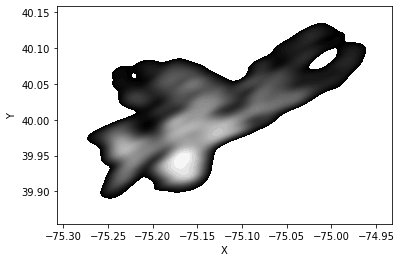

In [23]:
# could try a density (KDE) plot
sns.kdeplot(data=street_poles_df, x='X', y='Y', n_levels=50, shade=True, cmap='binary_r')

* Not sure that that really works that well either

In [ ]:
# Prof. O'Donnell suggested using a hexplot instead
# Much easier to use the df instead of GDF because extracting the x and y from geometry is annoying
base=districts_gdf.plot(color='black', edgecolor='white')
street_poles_df.plot.hexbin(x='X', y='Y', 
                            ax=base, 
                            column='OBJECTID', gridsize=100)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Street Poles Hexbin Plot')

districts_gdf.apply(show_district_nums, axis=1)

plt.xticks(rotation=60)
plt.yticks(rotation=30)
# Show the plot
plt.show()

### <font color="green"> Join data and inspect </font>
For the next graph, we will use an `sjoin` in order to map the street poles more clearly by district. Because the street pole data does not contain district ID, we will use the geometry to determine what district the street pole is in, which will allow us to map the street pole data by district. 
- We can see the pole count by district, which will be applied in the heatmap as a darker shade referring to a larget pole count. 
- We can check to see that the join worked by taking a sample table of the data and noting the columns from the 

In [17]:
# use an sjoin as suggested by Prof. O'Donnell
pole_district_gdf = gpd.sjoin(simple_sp_gdf, districts_gdf, how='left', op='within')
pole_district_gdf.head(3)


,OBJECTID_left,geometry,index_right,OBJECTID_right,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,centX,centY
0,1,POINT (-75.06641 40.04477),6.0,349.0,None,63587.369399,2.0,None,2.0,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,-75.081508,40.050009
1,2,POINT (-75.06118 40.04186),6.0,349.0,None,63587.369399,2.0,None,2.0,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,-75.081508,40.050009
2,3,POINT (-75.14445 40.00828),11.0,354.0,None,49749.035020,25.0,None,25.0,None,25,3700 Whittaker Ave,686-3250,EPD,1.179874e+08,1.870673e+07,19809.830073,-75.131465,40.009320


In [18]:
pole_counts = pole_district_gdf.groupby('district')['OBJECTID_left'].count().reset_index()
pole_counts.rename(columns={'OBJECTID_left': 'pole_count'}, inplace=True)
pole_counts

,district,pole_count
0,1.0,5137
1,2.0,9712
2,3.0,11447
3,5.0,6128
4,6.0,6542
5,7.0,10447
6,8.0,10414
7,9.0,6335
8,12.0,10248
9,14.0,14640


In [19]:
district_pole_gdf = districts_gdf.merge(pole_counts, on='district', how='right')


district_pole_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,pole_count
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,5137
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,9712
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,11447


### <font color="green"> Heatmap Steps </font>
- Plot the poles and police districts into a heatmap using the `.plot()` function 
With the now joined data, we can create a heatmap to best illustrate the amount of street poles per district. Here, we took note of the expressive principle: the darker green shading correlates with the more dense amount of street lights in a district. 
- Interestingly, district 15 appears to have the most street light compared to other districts. 
    - This could be attributed to an attempt to keep the district safe or one could also note the size of the district. When regarding the larger size of the district, it could make sense that it has the most street lights, as it needs to cover more area with light. The districts around Center City could have a higher density of lights per square foot of area, but because the districts are much smaller, the count of lights is smaller than that in the districts like 14 and 15. 

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

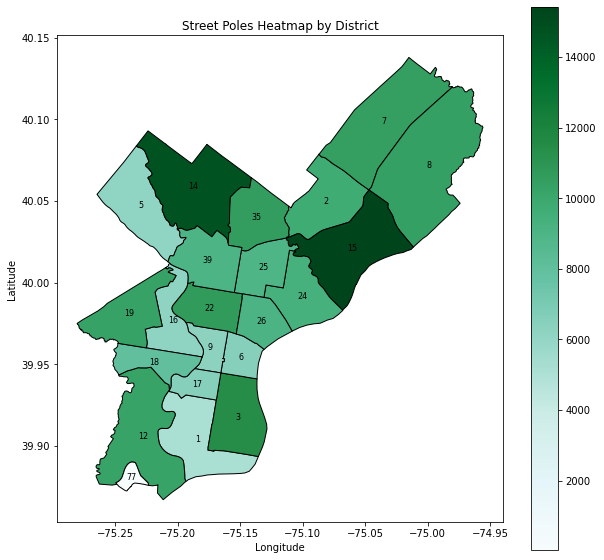

In [20]:
# plotting heatmap
fig, ax = plt.subplots(figsize=(10,10))
district_pole_gdf.plot(column='pole_count', cmap='BuGn', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Street Poles Heatmap by District')

dplot=districts_gdf.apply(show_district_nums, axis=1)


## <font color="red"> Time to Aggregate and Inspect the Crime + Street Light Data </font> 

INSTRUCTIONS for main analysis
1. Aggregate # of street poles per district using geodata
2. Plot for visual 
3. Heatmap it 
4. Aggregate crime (then split into granular types of crime) per district
    - Filter by nightfall, day vs night
5. Find correlation between variables (NOT NECESSARILY CAUSATION), and heatmap that

In [21]:
# ideas for more analysis
# differentiate the types of street poles, and find out more about them and how they pertain to other variables

### <font color="red">  Inspection Observations </font> 
In the following steps, we can read in the data and see that there are 18 columns, and 30,759 observations of crime from the 2022 dataset. 
- We chose 2022 because it was a full set of data 
- Key columns include `district` and `dispatch date`. We can use the district data to graph crime by police district, similar to the light map. We can also look at dispatch date to note how the CSV file we are looking at will reference 2022 data. 

In [25]:
crime_df = pd.read_csv('../data/crime.csv')

In [26]:
crime_df.shape

(30759, 18)

In [27]:
crime_df.columns

Index(['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist',
       'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour_',
       'dc_key', 'location_block', 'ucr_general', 'text_general_code',
       'point_x', 'point_y', 'lat', 'lng'],
      dtype='object')

In [23]:
crime_df.rename(columns={'dc_dist': 'district'}, inplace=True)
crime_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210204,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223360,12,1,2022-08-22 22:31:00+00,2022-08-22,18:31:00,NaN,202212047884,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
1,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210205,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223361,12,1,2022-10-07 21:12:00+00,2022-10-07,17:12:00,NaN,202212057333,8800 BLOCK BARTRAM AV,600,Thefts,-75.247645,39.886841,39.886841,-75.247645
2,0101000020E6100000A9EEFC68D9CF52C01CA7950084F1...,210206,0101000020110F0000CF182A5F34F45FC17876FBF9D97F...,223362,12,1,2022-08-18 03:14:00+00,2022-08-17,23:14:00,NaN,202212046997,8800 BLOCK BARTRAM AV,600,Theft from Vehicle,-75.247645,39.886841,39.886841,-75.247645


### <font color="red"> Checking what column to join by </font> 
After renaming the columns to more easily refer to district, we can look into merging the PDD data and crime data. 
- Since the district data matches up, we can join the df by that column

In [31]:
# focus year?? 2022?
pd.to_datetime(crime_df['dispatch_date_time']).dt.year.unique()

array([2022])

In [24]:
# comparing districts to sanity check the data
print(districts_gdf['district'].nunique())
print(crime_df['district'].nunique())

if (districts_gdf['district'].nunique() == crime_df['district'].nunique()):
    print('Yay! Districts matchup for each')

22
22
Yay! Districts matchup for each


### <font color="red"> Night crime filter </font> 
- In the following code, we filter by crimes at night in order to answer our question more accurately, and since the crime data includes the hour the crime occurred, we can filter by general dark hours. 
- We can also look into the unique kinds of crime which are observed in the dataset, in order to later be able to filter by types of crime. 

In [25]:
# getting the crimes at night
night_crime_df = crime_df[(crime_df['hour_'] >= 20) | (crime_df['hour_'] <= 8)]
night_crime_df.head(3)

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
5348,NaN,2831466,NaN,2895059,77,A,2022-08-02 00:31:00+00,2022-08-01,20:31:00,20.0,202277004022,B C Baggage Claim,600,Thefts,NaN,NaN,NaN,NaN
5351,NaN,2832239,NaN,2895062,26,3,2022-08-03 03:26:00+00,2022-08-02,23:26:00,23.0,202226028877,2600 BLOCK E York St,600,Thefts,NaN,NaN,NaN,NaN
5352,0101000020E6100000000000000000F87F000000000000...,2832410,NaN,2930002,24,2,2022-06-21 02:20:00+00,2022-06-20,22:20:00,22.0,202224036009,Address Unavailable,1300,Receiving Stolen Property,NaN,NaN,NaN,NaN


In [26]:
# i can't really work around the varying nightfall, like how it's dark by 6pm during the winter... 
# i've just generalized to 10pm to 8am
night_crime_df['hour_'].unique()

array([20., 23., 22.,  7.,  3., 21.,  2.,  6.,  8.,  1.,  0.,  5.,  4.])

In [27]:
# different types of crime we can filter for later on
crime_df['text_general_code'].unique()

array(['Thefts', 'Theft from Vehicle', 'Robbery No Firearm',
       'Burglary Non-Residential', 'Aggravated Assault No Firearm',
       'Aggravated Assault Firearm', 'Robbery Firearm',
       'Burglary Residential', 'Rape', 'Motor Vehicle Theft', 'Fraud',
       'Receiving Stolen Property', 'Vandalism/Criminal Mischief',
       'Other Assaults', 'All Other Offenses',
       'Other Sex Offenses (Not Commercialized)', 'Weapon Violations',
       'Arson', 'Forgery and Counterfeiting',
       'Narcotic / Drug Law Violations',
       'Offenses Against Family and Children', 'Disorderly Conduct',
       'DRIVING UNDER THE INFLUENCE', 'Embezzlement',
       'Prostitution and Commercialized Vice', 'Public Drunkenness',
       'Liquor Law Violations', 'Gambling Violations'], dtype=object)

### <font color="red"> Sunset data </font> 
    
* Could also scrape from https://sunrise.maplogs.com/philadelphia_pa_usa.291.html
* Did a copy-paste for 2022 and put in a TSV (tab separated value) file
    - `philadelphia_sunset_2022.tsv`
    
</div>

In [33]:
sunset_df = pd.read_csv('../data/philadelphia_sunset_2022.tsv', sep='\t')

In [34]:
sunset_df

,Date,Sunrise,Sunset,Daylength
0,01/01/2022,07:22:22 AM,04:46:55 PM,9h 24m 33s
1,01/02/2022,07:22:26 AM,04:47:47 PM,9h 25m 21s
2,01/03/2022,07:22:28 AM,04:48:40 PM,9h 26m 12s
3,01/04/2022,07:22:28 AM,04:49:34 PM,9h 27m 6s
4,01/05/2022,07:22:25 AM,04:50:30 PM,9h 28m 5s
...,...,...,...,...
360,12/27/2022,07:21:25 AM,04:42:51 PM,9h 21m 26s
361,12/28/2022,07:21:40 AM,04:43:34 PM,9h 21m 54s
362,12/29/2022,07:21:54 AM,04:44:19 PM,9h 22m 25s
363,12/30/2022,07:22:05 AM,04:45:06 PM,9h 23m 1s


* Can merge this into the crime data using the date field and then use as a filter for crime after dark.

* Of course this doesn't necessary align exactly with when the lights are actually illuminated.

## <font color="red"> Question: Is the geographical distribution of Philly crime denser in certain police districts? </font>

### <font color="red"> Key columns </font>

* The police district field will be used for grouping to observe trends
* We will first summarize the data then graph it

### <font color="red"> Steps </font>

* Use the district data in the crime data to map where the lights are present. 
* Try a heatmap to illustrate where the night crime is most dense. 

## <font color="red"> Summarize the Crime Data </font> 

- Let's check the amount of crimes and check out the table of data
    - We can summarize the data and note the number of night crimes in a specific district by count. 
- We can now merge the night crime and district data to create a heatmap. 
    - This'll help with heat mapping properly.

In [28]:
# ALL night crimes per district (note: we want to seperate the crimes using filters)
night_crime_counts = night_crime_df.groupby('district')['objectid'].count().to_frame(name='all_night_crimes').reset_index()
night_crime_counts

,district,all_night_crimes
0,1,197
1,2,391
2,3,328
3,5,118
4,6,472
5,7,120
6,8,302
7,9,405
8,12,645
9,14,321


In [29]:
district_crime_gdf = districts_gdf.merge(night_crime_counts, on='district', how='right')

district_crime_gdf

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_night_crimes
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,197
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,391
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,328
3,358,None,71919.797243,5,None,5,None,05,Ridge Ave. & Cinnaminson St.,686-3050,NWPD,2.130442e+08,3.381557e+07,28662.589764,"POLYGON ((-75.20430 40.03468, -75.20403 40.034...",-75.229553,40.047595,118
4,359,None,34655.320856,6,None,6,None,06,11th St. & Winter St.,686-3060,CPD,6.927927e+07,1.096654e+07,13788.505692,"POLYGON ((-75.13437 39.95294, -75.13524 39.950...",-75.149072,39.954649,472
5,360,None,90379.409963,7,None,7,None,07,Bustleton Ave. & Bowler St,686-3070,NEPD,3.460930e+08,5.501671e+07,36037.229512,"POLYGON ((-74.99854 40.12821, -74.99789 40.127...",-75.035176,40.098711,120
6,361,None,102386.230348,8,None,8,None,08,Academy Rd. & Red Lion Rd.,686-3080,NEPD,4.742013e+08,7.532290e+07,40817.729791,"POLYGON ((-74.97567 40.12021, -74.97557 40.120...",-74.999219,40.072206,302
7,362,None,38272.901992,9,None,9,None,09,21st St. & Pennsylvania Ave.,686-3090,CPD,5.840910e+07,9.247450e+06,15228.182451,"POLYGON ((-75.16366 39.95339, -75.16333 39.953...",-75.173806,39.960561,405
8,363,None,109036.337130,12,None,12,None,12,65th St. & Woodland Ave.,686-3120,SWPD,3.114690e+08,4.923350e+07,43355.190539,"POLYGON ((-75.22089 39.94785, -75.22040 39.947...",-75.227720,39.905890,645
9,364,None,93080.641065,14,None,14,None,14,Haines St. & Germantown Ave.,686-3140,NWPD,3.240713e+08,5.145609e+07,37097.945908,"POLYGON ((-75.19084 40.07413, -75.18968 40.073...",-75.187237,40.059059,321


## <font color="red"> Heatmap the Crime Data </font> 

- From the counts and the graph, we can see that districts 8 and 16 have the highest number of crimes. 
    - District 8 is rather large, so the more standout district could be district 16, which despite its smaller area, has one of the highest counts of crimes.
    - District 16 borders Drexel and UPenn's campus, so as Drexel and Penn continue to buy out areas, it is possible this amount of crimes will be pushed out to different districts.
    
*One note is the lack of data in the Center City districts, which we will attempt to fix, but regarding outside those areas still exhibits the above interesting significance*

### <font color="red"> Steps </font>
1. Use the `.plot()` function to map where the crimes are on the map 
2. Debug and make sure all districts are showing data


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

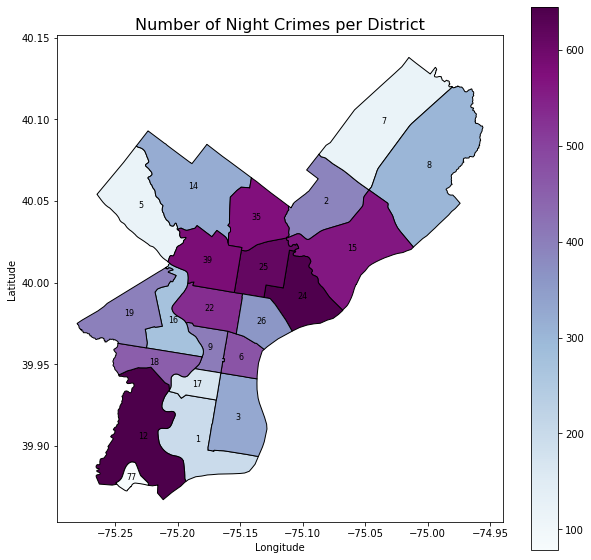

In [30]:
# heat map of all crimes

fig, ax = plt.subplots(figsize=(10,10))
district_crime_gdf.plot(column='all_night_crimes', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

In [31]:
# why are there empty spots...
# update 4/22, FIXED IT!!!
district_crime_gdf[district_crime_gdf['DIST_NUM']==35]


,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_night_crimes
19,346,None,51597.051603,35,None,35,None,35,N. Broad St. & Champlost St.,686-3350,NWPD,1.544309e+08,2.450685e+07,20554.869138,"POLYGON ((-75.13011 40.05789, -75.12898 40.057...",-75.137001,40.039976,573


#### scaling crime and pole count by size of region/district?

* Think about how you might scale these data by the size of the region - you can get that from the geometry in the geodataframe

## <font color="magenta"> Correlation for our Conclusion </font> 

Finally, for the point of our research project, we want to correlate whether the presence of street lights helps decrease the amount of crime in a district. 
- To do so, we will correlate the data in a combined table and graph. 

## <font color="magenta"> Question: Is the amount of light correlated with the amount of crimes in PPD districts? </font> 

### <font color="magenta"> Key columns

* The pole count field will help count the number of poles per district. 
* The night crimes field will count the number of crimes at night per district. 
* The district field will help us divide data into regions. 

### <font color="magenta"> Steps

1. Inspect the data, fixing any inconsistencies, duplicated, etc. 
2. Sort districts by ascending order 
3. Select the pole counts and night crimes
4. Calculate the correlation between pole counts and night crimes using `.corr()`

In [32]:
# finding correlation between crime and light in their respective districts
# output may be screwed up by the lack of crime data for several districts
# Aggregate the number of street poles per district

# Merge the two dataframes on the 'DISTRICT_' column
combined_df = pd.merge(pole_counts, night_crime_counts, on='district')
combined_df

,district,pole_count,all_night_crimes
0,1.0,5137,197
1,2.0,9712,391
2,3.0,11447,328
3,5.0,6128,118
4,6.0,6542,472
5,7.0,10447,120
6,8.0,10414,302
7,9.0,6335,405
8,12.0,10248,645
9,14.0,14640,321


In [2]:
combined_df[['pole_count', 'all_night_crimes']].corr()

NameError: name 'combined_df' is not defined

**General Rule:** A decent correlation coefficient value ranges from 0.5 to 0.7, with values closer to 1 indicating a stronger positive correlation between the two variables. However, the significance of the correlation also depends on the context and the specific problem being analyzed.



**Our Conclusion:** From the correlation table, we can see that there is about a .478 correlation between the amount of street poles and the number of crimes at night. This correlation implies that the amount of street lights does affect the number of crimes. From our heatmaps and tables, where there are more street lamps there appears to be less overall crime. Thus, it is most likely a negative correlation between light and crime, as we hypothesized.

# <font color="cyan"> Further Analysis </font> 

Here, we will use filters in order to zoom in on different types of crime in correlation with light. We are still testing the same hypothesis of whether or not light affects crime, but this time we are splitting crime into severe crimes and petty crimes. 

## <font color="darkcyan"> Question: Is the amount of light correlated with the amount of severe crimes in PPD districts? What about with the petty crimes? Is there any difference between the amount of correlation? </font>

### <font color="darkcyan"> Key columns </font>

* The pole count field will help count the number of poles per district. 
* The night crimes field will count the number of crimes at night per district. 
* The district field will help us divide data into regions. 

### <font color="darkcyan"> Steps </font>

1. Inspect the data, fixing any inconsistencies, duplicated, etc. 
2. Filter by severe crimes vs. petty crimes by using the unique column names to organize the data into groups.
3. Sort districts by ascending order 
4. Select the pole counts and night crimes
5. Calculate the correlation between pole counts and night crimes using `.corr()`

## <font color="darkcyan"> Severe Crime Heat Map </font> 

- Following the same steps as the previous crime heatmap, but this time filtering for severe crimes

In [34]:
# creating a list of specific values
severe_crime = ['Aggravated Assault No Firearm', 'Aggravated Assault Firearm', 'Rape', 
                'Other Sex Offenses (Not Commercialized)', 'Arson', 'Offenses Against Family and Children']

# filter using above
severe_df = night_crime_df[night_crime_df['text_general_code'].isin(severe_crime)]
severe_df

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
5379,0101000020E61000005EB5F8358EC952C0AC09DC998D00...,2840142,0101000020110F000019536E9683E95FC128ACC1908290...,2859799,25,4,2022-08-09 01:33:00+00,2022-08-08,21:33:00,21.0,202225044278,3400 BLOCK Germantown Ave,400,Aggravated Assault No Firearm,-75.149305,40.004321,40.004321,-75.149305
5381,0101000020E61000001B8FC65F62C752C0D5EFDB738DFF...,2840144,0101000020110F0000149D6B71D3E55FC1BB938C93668F...,2859801,24,2,2022-04-16 06:26:00+00,2022-04-16,02:26:00,2.0,202224021587,800 BLOCK E ALLEGHENY AV,400,Aggravated Assault Firearm,-75.115379,39.996504,39.996504,-75.115379
5399,0101000020E610000037FF4C10B7CA52C07DB6ABE3BAF9...,2840292,0101000020110F0000964672D27BEB5FC148B127A6F288...,2855684,9,1,2022-08-01 12:54:00+00,2022-08-01,08:54:00,8.0,202209026644,1600 BLOCK Chestnut St,400,Aggravated Assault No Firearm,-75.167423,39.951016,39.951016,-75.167423
5405,0101000020E6100000296101A7D2C752C04CE970DFB002...,2840298,0101000020110F00009242B02892E65FC1F352CF6DE192...,2855690,25,2,2022-05-05 06:11:00+00,2022-05-05,02:11:00,2.0,202225024131,200 BLOCK E Wyoming,400,Aggravated Assault Firearm,-75.122232,40.021023,40.021023,-75.122232
5407,0101000020E6100000C566B24573C952C00F32C1579103...,2840300,0101000020110F0000281E6AD455E95FC1BBF65462DA93...,2855692,35,2,2022-03-07 02:16:00+00,2022-03-06,21:16:00,21.0,202235012506,4900 BLOCK N BROAD ST,400,Aggravated Assault Firearm,-75.147661,40.027873,40.027873,-75.147661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30670,0101000020E61000001E2B6309CCC852C059B3635DBBFD...,2880977,0101000020110F00007E1066C339E85FC1F882C1E9618D...,2879654,26,1,2022-04-25 02:08:00+00,2022-04-24,22:08:00,22.0,202226014539,2100 BLOCK N PHILIP ST,400,Aggravated Assault Firearm,-75.137453,39.982280,39.982280,-75.137453
30691,0101000020E61000008DB34C339BC852C023ECA19EBA03...,2880998,0101000020110F0000FA3458CFE6E75FC199A58A2A0894...,2880205,35,2,2022-04-19 04:55:00+00,2022-04-19,00:55:00,0.0,202235021142,600 BLOCK LINDLEY AV,200,Rape,-75.134473,40.029133,40.029133,-75.134473
30728,0101000020E610000068E8E1FCF4CD52C002AA6EE470F8...,2881035,0101000020110F000034BD1F88FDF05FC19A8578138587...,2874173,12,3,2022-01-22 05:37:00+00,2022-01-22,00:37:00,0.0,202212003763,1300 BLOCK S PAXON ST,400,Aggravated Assault No Firearm,-75.218078,39.940945,39.940945,-75.218078
30729,0101000020E6100000EE82B9C46ECE52C0E51F22DA33F7...,2881036,0101000020110F000022DC6D63CCF15FC15D9449E82586...,2874174,12,3,2022-03-09 02:50:00+00,2022-03-08,21:50:00,21.0,202212012705,5800 BLOCK WOODLAND AV,400,Aggravated Assault No Firearm,-75.225511,39.931270,39.931270,-75.225511


In [35]:
severe_counts = severe_df.groupby('district')['objectid'].count().to_frame(name='all_severe').reset_index()
severe_counts

,district,all_severe
0,1,14
1,2,39
2,3,23
3,5,15
4,6,53
5,7,8
6,8,21
7,9,24
8,12,67
9,14,31


In [36]:
dist_sev_gdf = districts_gdf.merge(severe_counts, on='district', how='right')
dist_sev_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_severe
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,14
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,39
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,23


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

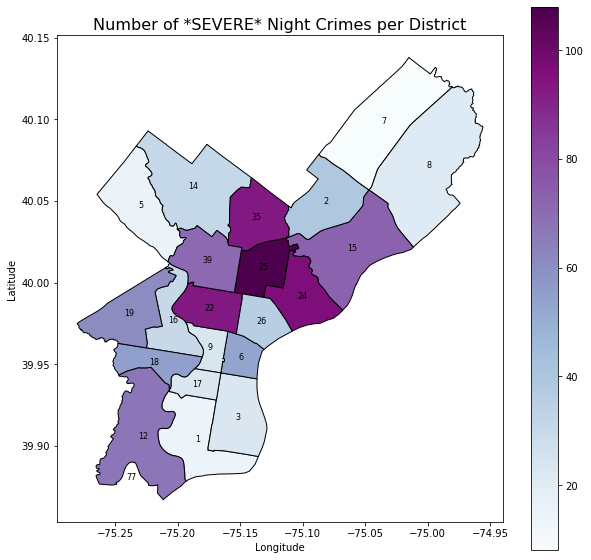

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
dist_sev_gdf.plot(column='all_severe', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of *SEVERE* Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

## <font color="darkcyan"> Petty Crime Heat Map <font/>

- Following the same steps as the previous crime heatmap, but this time filtering for petty crime

In [38]:
# creating a list of specific values
petty_crime = ['Thefts', 'Theft from Vehicle', 'Robbery No Firearm', 'Burglary Non-Residential', 
               'Vandalism/Criminal Mischief', 'Disorderly Conduct', 'DRIVING UNDER THE INFLUENCE', 
               'Prostitution and Commercialized Vice', 'Public Drunkenness', 'Liquor Law Violations', 
               'Gambling Violations']

# filter using above
petty_df = night_crime_df[night_crime_df['text_general_code'].isin(petty_crime)]
petty_df

,the_geom,cartodb_id,the_geom_webmercator,objectid,district,psa,dispatch_date_time,dispatch_date,dispatch_time,hour_,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
5348,NaN,2831466,NaN,2895059,77,A,2022-08-02 00:31:00+00,2022-08-01,20:31:00,20.0,202277004022,B C Baggage Claim,600,Thefts,NaN,NaN,NaN,NaN
5351,NaN,2832239,NaN,2895062,26,3,2022-08-03 03:26:00+00,2022-08-02,23:26:00,23.0,202226028877,2600 BLOCK E York St,600,Thefts,NaN,NaN,NaN,NaN
5356,0101000020E6100000000000000000F87F000000000000...,2833571,NaN,2938042,3,3,2022-04-12 00:56:00+00,2022-04-11,20:56:00,20.0,202203013957,0 BLOCK CITIZENS BANK WAY,2200,Liquor Law Violations,NaN,NaN,NaN,NaN
5357,0101000020E6100000000000000000F87F000000000000...,2833657,NaN,2938043,3,3,2022-04-12 00:56:00+00,2022-04-11,20:56:00,20.0,202203013958,0 BLOCK CITIZENS BANK WAY,2200,Liquor Law Violations,NaN,NaN,NaN,NaN
5358,0101000020E6100000000000000000F87F000000000000...,2833872,NaN,2938044,3,3,2022-04-12 00:56:00+00,2022-04-11,20:56:00,20.0,202203013959,0 BLOCK CITIZENS BANK WAY,2200,Liquor Law Violations,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30736,0101000020E6100000A33CF37258CE52C0CCDC95C05AF7...,2881043,0101000020110F00002A17027AA6F15FC197C50DFE5086...,2874181,12,3,2022-03-19 02:56:00+00,2022-03-18,22:56:00,22.0,202212014728,5700 BLOCK Woodland Ave,600,Thefts,-75.224148,39.932457,39.932457,-75.224148
30737,0101000020E6100000A33CF37258CE52C0CCDC95C05AF7...,2881044,0101000020110F00002A17027AA6F15FC197C50DFE5086...,2874182,12,3,2022-04-10 05:04:00+00,2022-04-10,01:04:00,1.0,202212019174,5700 BLOCK WOODLAND AV,300,Robbery No Firearm,-75.224148,39.932457,39.932457,-75.224148
30742,0101000020E6100000DBE14C9F5FCF52C04195A2AE98F6...,2881049,0101000020110F0000737AB98065F35FC178694D0D7A85...,2874187,12,2,2022-06-29 01:21:00+00,2022-06-28,21:21:00,21.0,202212036711,6700 BLOCK REGENT ST,600,Thefts,-75.240211,39.926534,39.926534,-75.240211
30745,0101000020E61000001F4BFEAB77CF52C0DEEAF7CCABF3...,2881052,0101000020110F000091B57C5A8EF35FC14AC157CF3C82...,2874190,12,1,2022-07-09 12:40:00+00,2022-07-09,08:40:00,8.0,202212038746,7700 BLOCK LINDBERGH BLVD,600,Theft from Vehicle,-75.241679,39.903680,39.903680,-75.241679


* evidently more cells, more petty crime

In [39]:
petty_counts = petty_df.groupby('district')['objectid'].count().to_frame(name='all_petty').reset_index()
petty_counts

,district,all_petty
0,1,144
1,2,202
2,3,243
3,5,64
4,6,255
5,7,81
6,8,185
7,9,230
8,12,190
9,14,120


In [40]:
dist_pet_gdf = districts_gdf.merge(petty_counts, on='district', how='right')
dist_pet_gdf.head(3)

,OBJECTID,AREA,PERIMETER,district,DISTRICT_ID,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,Shape__Area,Shape__Length,geometry,centX,centY,all_petty
0,348,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,3.419657e+07,32552.488256,"POLYGON ((-75.19724 39.92944, -75.19693 39.929...",-75.183562,39.904282,144
1,349,None,63587.369399,2,None,2,None,02,7306 Castor Ave,686-3020,NEPD,1.923461e+08,3.053264e+07,25329.930167,"POLYGON ((-75.05444 40.04454, -75.05482 40.044...",-75.081508,40.050009,202
2,350,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,2.907948e+07,22002.676793,"POLYGON ((-75.13205 39.89932, -75.13470 39.894...",-75.151662,39.917482,243


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
dtype: object

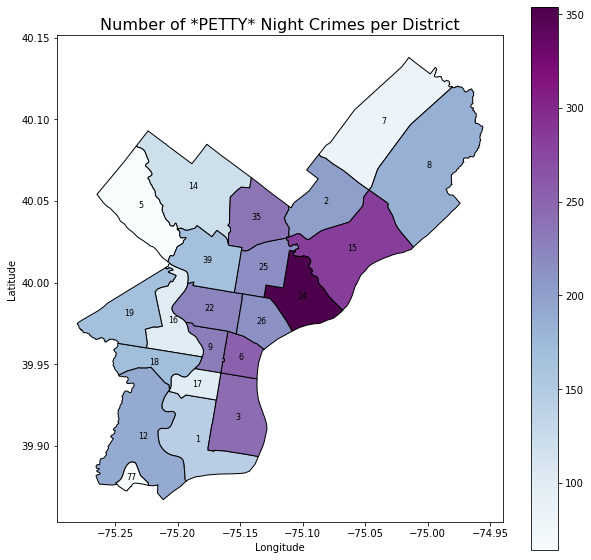

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
dist_pet_gdf.plot(column='all_petty', cmap='BuPu', linewidth=1, ax=ax, edgecolor='black', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Number of *PETTY* Night Crimes per District', fontsize=16)
districts_gdf.apply(show_district_nums, axis=1)

## <font color="darkcyan"> Final Correlation Matrices for 'Severe' and 'Petty' Crime <font/>

**Our Conclusion:** 
From the petty crime correlation table, we can see that there is about a .43 correlation between the amount of street poles and the number of petty crimes at night. This correlation implies that the amount of street lights does affect the number of petty crimes. 

However, the severe crime correlation tableillustrates only a .29 correlation between the amount of street poles and the number of severe crimes at night. This weak correlation implies that the amount of street lights does not affect the number of severe crimes as much as it does the petty crimes. 

In [42]:
# severe vs. poles 
severe_corr_df = pd.merge(pole_counts, severe_counts, on='district')
severe_corr_df

,district,pole_count,all_severe
0,1.0,5137,14
1,2.0,9712,39
2,3.0,11447,23
3,5.0,6128,15
4,6.0,6542,53
5,7.0,10447,8
6,8.0,10414,21
7,9.0,6335,24
8,12.0,10248,67
9,14.0,14640,31


In [43]:
severe_corr_df[['pole_count', 'all_severe']].corr()

,pole_count,all_severe
pole_count,1.000000,0.290527
all_severe,0.290527,1.000000


In [44]:
# petty vs. poles 
petty_corr_df = pd.merge(pole_counts, petty_counts, on='district')
petty_corr_df

,district,pole_count,all_petty
0,1.0,5137,144
1,2.0,9712,202
2,3.0,11447,243
3,5.0,6128,64
4,6.0,6542,255
5,7.0,10447,81
6,8.0,10414,185
7,9.0,6335,230
8,12.0,10248,190
9,14.0,14640,120


In [45]:
petty_corr_df[['pole_count', 'all_petty']].corr()

,pole_count,all_petty
pole_count,1.000000,0.430471
all_petty,0.430471,1.000000


<div class="alert alert-info">
    
### Some comments
    
* This is all really good work and you've made some really good progress.
    
* I think the Police districts are a good starting point but I suspect it is too coarse grained.
    
* Think about repeating the same process but with something like neighborhoods:
    - e.g. https://github.com/blackmad/neighborhoods/blob/master/gn-philadelphia.geojson
    
    
* Then I would select one or two specific districts (one high one low on crime of specific type) and do a more close analysis that would look at the density of street poles. Could use the size of the polygon for district/neighborhood to normalize the pole count and crime incidents.
</div>